# **Bats VS Rats Analysis**

In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from scipy.stats import binomtest
from scipy.stats import pearsonr
from math import sqrt
from scipy.stats import norm

In [254]:
df1 = pd.read_csv("dataset1.csv")
df2 = pd.read_csv("dataset2.csv")

## General Analysis of Datasets

General analysis to see the magnitude of the data.
From this perspective, it is not valuable to perform a join because the number of bat landings in dataset1 is minimal compared to the actual amount of bat landings. Since the videos last 30 minutes and include multiple landings within this period, we cannot reliably associate the information from a recording with a specific landing.

In [255]:
Lenght_df2 = df2.shape[0]
Lenght_df1 = df1.shape[0]
total_landing = df2["bat_landing_number"].sum()
print(f"Total number of landings: {total_landing},\nbut dataset2 has {Lenght_df2} rows and dataset1 has {Lenght_df1} rows.")
print(f"This means that: \n1. Not all the landings are recorded\n2. We have more videos recordings that bat landings.")

Total number of landings: 68113,
but dataset2 has 2123 rows and dataset1 has 907 rows.
This means that: 
1. Not all the landings are recorded
2. We have more videos recordings that bat landings.


In [256]:
df1.head()

,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


### Data Wrangling

In this part, we analyze which variables we should use and in which format.
Our first approach was to identify the scenarios where landings occurred during the presence of rats and to analyze whether the bats’ actions changed when rats were present. For this reason, we created several time-related columns to help determine whether a rat was present at the moment of a landing.

Our original idea was to define a proxy for fear in the bats’ behavior and to analyze whether the probability of this behavior changed in the presence of rats.

Here we created several columns, not all of which were ultimately used in the final analysis, but they helped us check whether our initial theories were feasible or not. Specifically, we created:

RAT_PRESENCE: We thought that the behavior of bats might change in the presence of rats, so we created this column to identify whether a rat was present at the time of a bat’s landing.

RAT_DURATION_SEC: This variable indicates how long a rat stayed on the platform. We assumed that the length of the rat’s stay could affect the bats’ behavior.

BAT_LANDING_AFTER_SUNSET_SEC: We thought that the time of day could influence bat behavior, assuming that at night bats might be less fearful than during the day.

BAT_EAT_WITH_RAT: This variable indicates whether the bat ate in the presence of rats or waited until the rats left. This was the variable we ultimately used, since in later analyses we discovered that the others were not feasible with the available data. 

In [257]:
# DATETIME FORMAT
df1['start_time'] = pd.to_datetime(df1['start_time'], format='%d/%m/%Y %H:%M')
df1['rat_period_start'] = pd.to_datetime(df1['rat_period_start'], format='%d/%m/%Y %H:%M')
df1['rat_period_end'] = pd.to_datetime(df1['rat_period_end'], format='%d/%m/%Y %H:%M')
df1['sunset_time'] = pd.to_datetime(df1['sunset_time'], format='%d/%m/%Y %H:%M')

# Did the Bat eat with the rats or just wait?
df1['BAT_EATING_TIME'] = df1['start_time'] + pd.to_timedelta(df1['bat_landing_to_food'], unit='s')
df1['BAT_EAT_WITH_RAT_SEC'] = (df1['BAT_EATING_TIME'] - df1['rat_period_end']).dt.total_seconds()
df1['BAT_EAT_WITH_RAT'] = np.where(df1['BAT_EAT_WITH_RAT_SEC'] < 0, 1, 0)

# EXTRACT DATES OF ACTIONS
df1['RAT_ARRIVING_DATE'] = df1['rat_period_start'].dt.strftime('%d/%m/%Y')
df1['RAT_LEAVING_DATE'] = df1['rat_period_end'].dt.strftime('%d/%m/%Y')
df1['SUNSET_DATE'] = df1['sunset_time'].dt.strftime('%d/%m/%Y')
df1['DATE'] = df1['start_time'].dt.strftime('%d/%m/%Y')


# EXTRACT TIME OF ACTIONS
df1['BAT_LANDING_TIME'] = df1['start_time'].dt.strftime('%H:%M')
df1['RAT_ARRIVING_TIME'] = df1['rat_period_start'].dt.strftime('%H:%M')
df1['RAT_LEAVING_TIME'] = df1['rat_period_end'].dt.strftime('%H:%M')
df1['SUNSET_TIME'] = df1['sunset_time'].dt.strftime('%H:%M')

# DURATION OF ACTIONS
df1['RAT_DURATION_SEC'] = ((pd.to_timedelta(df1['RAT_LEAVING_TIME']+ ':00') - pd.to_timedelta(df1['RAT_ARRIVING_TIME']+ ':00')).dt.total_seconds()).astype(int)
df1['hours_after_sunset'] = (df1['hours_after_sunset']*3600).astype(int)

# RAT PRESENCE BEFORE BAT LANDING
df1['RAT_PRESENCE'] = ((pd.to_timedelta(df1['BAT_LANDING_TIME']+ ':00') - pd.to_timedelta(df1['RAT_ARRIVING_TIME']+ ':00')).dt.total_seconds()).astype(int)
df1['RAT_PRESENCE'] = np.where(df1['RAT_PRESENCE'] < 0, 0, 1)
# CHANGE NAME OF COLUMNS
df1.rename(columns={
    'bat_landing_to_food' : 'BAT_LANDING_TO_FOOD_SEC',
    'seconds_after_rat_arrival': 'BAT_LANDING_AFTER_RAT_SEC',
    'risk' : 'RISK',
    'reward' : 'REWARD',
    'month' : 'MONTH',
    'season' : 'SEASON',
    'hours_after_sunset' : 'BAT_LANDING_AFTER_SUNSET_SEC',
    'habit':'HABIT'
}, inplace=True)

# REORGANIZE AND DROP INNECESARY COLUMNS
df1 = df1[['DATE','BAT_EAT_WITH_RAT','HABIT','RISK','RAT_PRESENCE','REWARD','BAT_LANDING_TIME','RAT_ARRIVING_TIME','RAT_LEAVING_TIME','SUNSET_TIME', 'BAT_LANDING_AFTER_RAT_SEC','BAT_LANDING_TO_FOOD_SEC','RAT_DURATION_SEC','BAT_LANDING_AFTER_SUNSET_SEC','MONTH', 'SEASON']]
df1

,DATE,BAT_EAT_WITH_RAT,HABIT,RISK,RAT_PRESENCE,REWARD,BAT_LANDING_TIME,RAT_ARRIVING_TIME,RAT_LEAVING_TIME,SUNSET_TIME,BAT_LANDING_AFTER_RAT_SEC,BAT_LANDING_TO_FOOD_SEC,RAT_DURATION_SEC,BAT_LANDING_AFTER_SUNSET_SEC,MONTH,SEASON
0,30/12/2017,1,rat,1,1,0,18:37,18:35,18:38,16:45,108,16.000000,180,6734,0,0
1,30/12/2017,1,fast,0,1,1,19:51,19:50,19:55,16:45,17,0.074016,300,11162,0,0
2,30/12/2017,1,fast,0,1,1,19:51,19:50,19:55,16:45,41,4.000000,300,11187,0,0
3,30/12/2017,1,rat,1,1,0,19:52,19:50,19:55,16:45,111,10.000000,300,11256,0,0
4,30/12/2017,1,rat,1,1,0,19:54,19:50,19:55,16:45,194,15.000000,300,11340,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,04/05/2018,1,rat,1,1,0,04:18,04:14,04:30,19:22,224,2.000000,960,32159,5,1
903,04/05/2018,1,fast,0,1,1,04:18,04:14,04:30,19:22,275,1.000000,960,32211,5,1
904,04/05/2018,1,pick,0,1,1,04:19,04:14,04:30,19:22,310,22.000000,960,32245,5,1
905,03/05/2018,1,fast,0,1,1,23:51,23:46,23:52,19:22,339,2.000000,360,16196,5,1


### First Analysis approach
Our initial idea was to determine whether the behavior of bats differed in the presence of rats. When we analyzed the data to check for both possible scenarios (with rats and without rats), we discovered that only one scenario exists: rats are always present before bat landings. This means we cannot evaluate the scenario both with and without rats, which would have been the ideal situation to compare differences between two samples. The code for this initial approach is shown below.

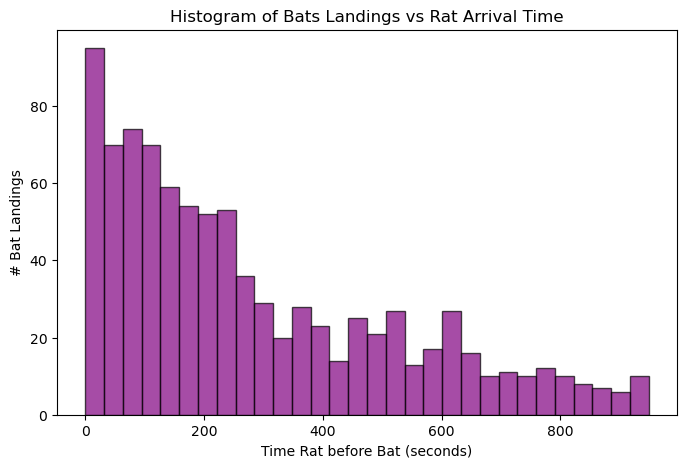

In [258]:
# PLOT HISTOGRAM OF RAT'S TIME BEFORE BAT LANDING
plt.figure(figsize=(8,5))
plt.hist(df1['BAT_LANDING_AFTER_RAT_SEC'], bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Time Rat before Bat (seconds)')
plt.ylabel('# Bat Landings')
plt.title('Histogram of Bats Landings vs Rat Arrival Time')
plt.show()

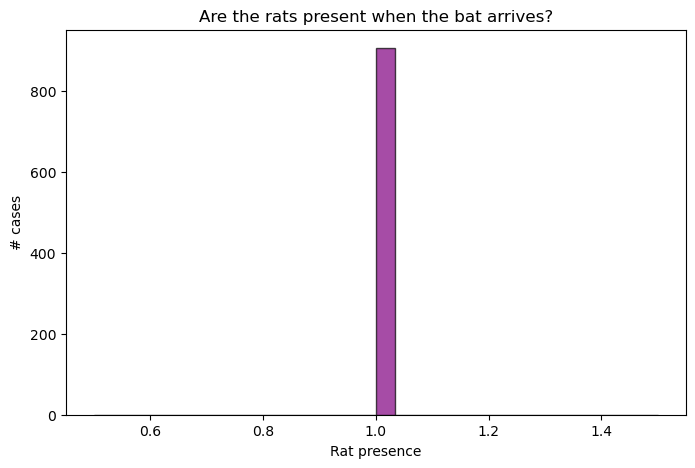

In [259]:
# PLOT HISTOGRAM OF RAT PRESENCE
plt.figure(figsize=(8,5))
plt.hist(df1['RAT_PRESENCE'], bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Rat presence')
plt.ylabel('# cases')
plt.title('Are the rats present when the bat arrives?')
plt.show()

Conclusion: Rats are always present before bat landings, which prevents us from conducting a hypothesis test to compare two different samples (with and without rats). The original idea was to compare two different scenarios, but with this dataset, it is not possible.

### Second point of view: Bats eat with rats or try to avoid eat with rats
We will analyze whether bats eat in the presence of rats or if they wait until the rats are gone. To do this, we will compare the time when the bat approaches the food with the period during which the rats are present. If the bat goes to eat while the rats are still there, the variable BAT_EAT_WITH_RAT will take the value 1. If the bat eats after the rats have left, it will take the value 0.


### Quick analysis of time to go for food
Before answering the question about how the distribution of bats eating with rats compares to bats eating without rats, we will first analyze whether bats go directly to eat or if the presence of rats makes them wait before approaching the food. Even though this is only a descriptive analysis, it could be useful as a first step to understand whether bats are trying to avoid the presence of rats.

Our initial hypothesis is: if bats are trying to avoid eating with rats, this would be reflected in a longer waiting period between landing and "going for food." If the distribution shows that bats are waiting longer, it could suggest that they are trying to find the right moment to approach the food because they see rats as potential predators and therefore feel scared.

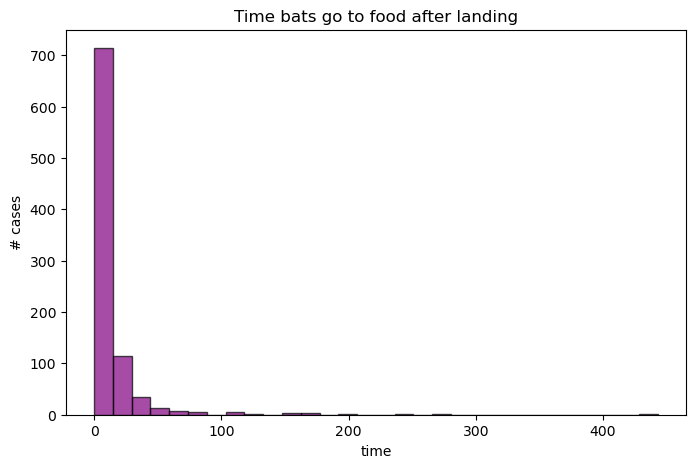

In [260]:
plt.figure(figsize=(8,5))
plt.hist(df1['BAT_LANDING_TO_FOOD_SEC'], bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('time')
plt.ylabel('# cases')
plt.title('Time bats go to food after landing')
plt.show()

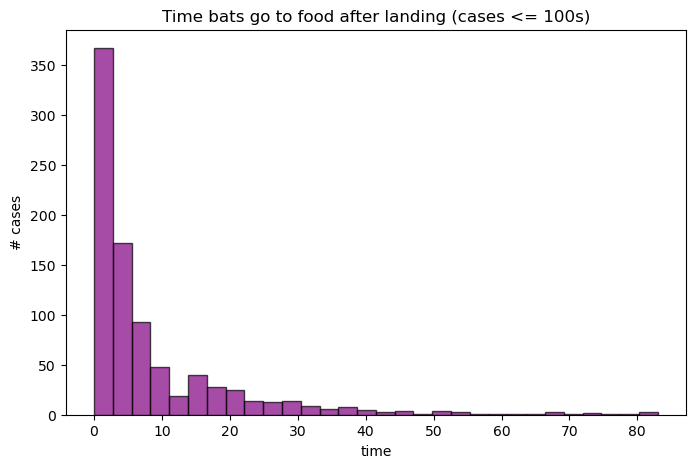

In [261]:
# Filter DataFrame to incluid cases where BAT_LANDING_TO_FOOD_SEC < 100 only.
df1_filtrado = df1[df1['BAT_LANDING_TO_FOOD_SEC'] <= 100]

plt.figure(figsize=(8,5))
plt.xticks(np.arange(0, 101, 10))
plt.hist(df1_filtrado['BAT_LANDING_TO_FOOD_SEC'], bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('time')
plt.ylabel('# cases')
plt.title('Time bats go to food after landing (cases <= 100s)')
plt.show()

If we look at the distribution of 'time to go for food,' we can see that the highest concentration of cases occurs in the first second after landing. This gives the impression that bats go straight to the food because they don’t perceive rats as a danger or predator.

In [262]:
# Create the string column'EAT_WITH_RAT_CAT' with values 'Yes' or 'Not'.
df1['EAT_WITH_RAT_CAT'] = np.where(df1['BAT_EAT_WITH_RAT'] == 1, 'Yes', 'Not')
# df1.head()

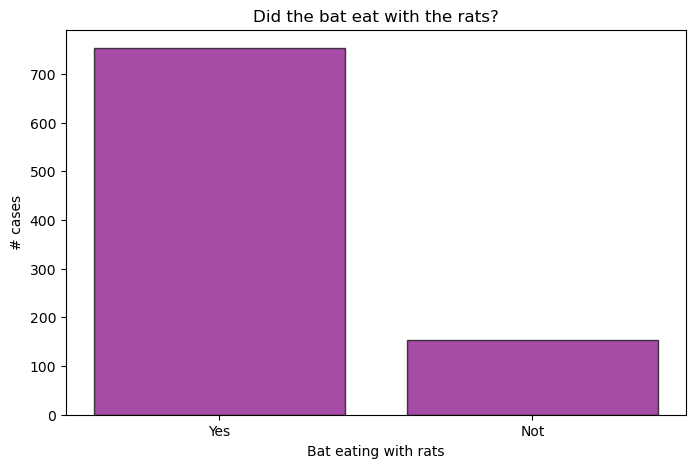

In [263]:
# Create the string column'EAT_WITH_RAT_CAT' with values 'Yes' or 'Not'.
df1['BAT_EAT_WITH_RAT_CAT'] = np.where(df1['BAT_EAT_WITH_RAT'] == 1, 'Yes', 'Not')

N_CASES = df1['BAT_EAT_WITH_RAT_CAT'].value_counts()

# 2. Bar plot of the N_CASES
plt.figure(figsize=(8,5))
plt.bar(N_CASES.index, N_CASES.values, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Bat eating with rats')
plt.ylabel('# cases')
plt.title('Did the bat eat with the rats?')
plt.show()

From the bar graph, it is possible to see that in the majority of cases, bats do not wait for the rats to leave before going to eat. This suggests that bats go to eat regardless of whether rats are present in most cases. This could mean that bats are not afraid of rats and are able to eat in their presence because they do not perceive rats as predators.

## Normal Histogram distribution of Bat eating with rats

To strengthen the analysis of the previous descriptive results, we will perform an inferential analysis to determine whether the descriptive findings can be confirmed through inferential statistics. For this analysis, we will rely on the Central Limit Theorem (CLT), which allows us to perform hypothesis tests because the sample means tend to follow a normal distribution with more than 30 cases.

First, we will plot the histogram of the distribution of means of the variable BAT_EAT_WITH_RAT per day. We have data for 67 days, which allows us to use the CLT to conduct a hypothesis test. This test will determine whether the probability of bats eating in the presence of rats is greater than 0.5. If it is, this would indicate that bats eat with rats more often than not, suggesting that they do not avoid eating with rats because they do not perceive them as predators.

### Graph of means distribution of BATS EATING WHIT RATS

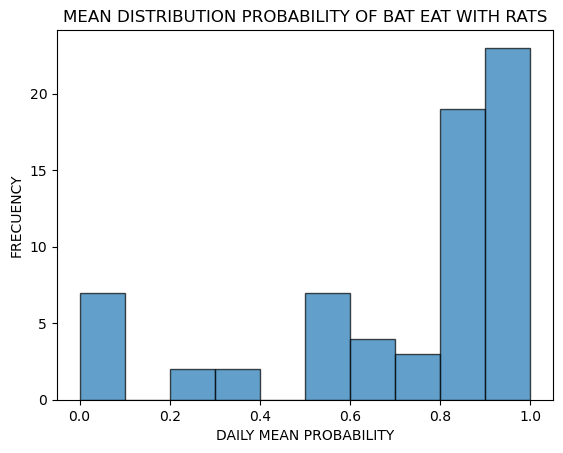

In [264]:
# Mean of BAT_EAT_WITH_RAT per day
df1_grouped = df1.groupby("DATE")["BAT_EAT_WITH_RAT"].mean().reset_index()

# Extract Column to Histogram
AVG_BAT_EAT_WITH_RAT = df1_grouped["BAT_EAT_WITH_RAT"]

# Graficar histograma
plt.hist(AVG_BAT_EAT_WITH_RAT, bins=10, edgecolor="black", alpha=0.7)
plt.title("MEAN DISTRIBUTION PROBABILITY OF BAT EAT WITH RATS")
plt.xlabel("DAILY MEAN PROBABILITY")
plt.ylabel("FRECUENCY")
plt.show()

From the graph, it is possible to see that the distribution is not perfectly normal; in fact, it has a right skew. In principle, this is not a problem for using the Central Limit Theorem (CLT), because it only shows that the distribution has a mean biased toward the value 1 and is limited by this. This serves as an initial approach to confirm that the distribution of the means is very likely greater than 0.5.

### Confidence Interval
An initial approach to analyze the inferential statistics of our hypothesis is to examine the confidence interval of the mean of our daily distribution

In [265]:
n = df1['DATE'].nunique()
confidence = 0.95
z = stats.norm.ppf(1 - (1 - confidence)/2)
mean = round(AVG_BAT_EAT_WITH_RAT.mean(),2)
SD = round(AVG_BAT_EAT_WITH_RAT.std(),2)
#Limits of IC
lower = round(mean - z*SD / np.sqrt(n),2)
upper = round(mean + z*SD / np.sqrt(n),2)
print("n=", n)
print("Z=", z)
print("mean =", mean)
print("Standard Desviation =", SD)
print(f"Confidence interval 95%: (",lower,"-", upper,")")

n= 67
Z= 1.959963984540054
mean = 0.72
Standard Desviation = 0.32
Confidence interval 95%: ( 0.64 - 0.8 )


The 95% confidence interval is between [0.64 – 0.8]. This means that, with 95% confidence, the daily mean of AVG_BAT_EAT_WITH_RAT falls within this range. This helps us conclude that, on average, the proportion of cases in which bats eat in the presence of rats is greater than 0.5. Consequently, this indicates that bats are not avoiding eating with rats.


## Hypothesis Test

Hypothesis

H0: P < 0.5 = Proportion of cases where bats eat with rats is lower than 0.5. (bats avoid eat when are rats)

H1: P > 0.5 = Proportion of cases where bats eat with rats is higher than 0.5. (bats don't avoid eat when are rats)

if p_value es < 0.05, H0 can't be supported and this means that bats eat mostly of the time in presence of rats.

In [266]:
n_total = df1["BAT_EAT_WITH_RAT"].count()
n_success = df1["BAT_EAT_WITH_RAT"].sum()
p_hat = n_success/n_total
p0 = 0.5
z = (p_hat - p0) / np.sqrt(p0*(1-p0)/n_total)
p_value = 1 - stats.norm.cdf(z)
print("Proporción observada:", round(p_hat,2))
print("z-statistic:", round(z,2))
print("p-value (una cola):", format(p_value,".4f"))

Proporción observada: 0.83
z-statistic: 19.89
p-value (una cola): 0.0000


The p-value measures how compatible the data are with the null hypothesis (H0). If the data are highly compatible with H0, then we cannot reject H0.

However, if the p-value is very small, it indicates that the data do not support H0. Basically, a large p-value means that H0 cannot be rejected.

The threshold we use to decide whether to accept or reject H0 is 0.05.

In this case, H0 ≈ 0, which means that the data do not support H0 and that bats are eating with rats in a proportion greater than 0.5.

### BINOMIAL TEST
How the distribution de of the means doesn't look normal, we will realize a Binomial Hipothesis Test because this kind of test don't depend of the CLT and don't requiere that the mean behave normally. For this test we need calculate the proportion of successful cases/ Total cases and define a H0. Our H0 will be p <= 0.5 (Bats eat with rats in a proportion lower than 0.5 / bats avoid eat when are rats). We will use a level of significance of 95 (This means that alpha = 0.05). If p_value < 0.05 we will reject H0 and the bats will eat mostly of the time with rats.

In [267]:
# Parameters

k = df1['BAT_EAT_WITH_RAT'].sum() # Number of successes (Bats eating with rats)
n = len(df1) # Total number of trials (Total bat landings)

# Probability of H0.
#  H0: p <= 0.5, because of that we choose the probability 0.5
p_hipotesis = 0.5

# Binomial Test
# H1: p> 0.5 (greater) => one-tailed test
result = binomtest(k, n, p=p_hipotesis, alternative='greater')
print("Result =", result)

Result = BinomTestResult(k=753, n=907, alternative='greater', statistic=0.8302094818081588, pvalue=1.1405278289457543e-95)


### Result
pvalue=1.14...e-95 <0.05
This mean that H0 is rejected and Bats eat mostly of the time with rats (Bats aren't avoiding rats).

## DF2: Register of recording videos

Although the recorded videos are aggregated, which means we cannot analyze each individual landing, performing a statistical analysis like the one before is not possible. The most useful analysis we can perform in this case is to evaluate the correlation between variables.

From this initial exploratory analysis, we can determine whether some variables are correlated with others. An interesting correlation to investigate could be whether the number of rats is negatively correlated with the number of bat arrivals. If such a correlation exists, it could indicate that the presence of rats affects the number of bat landings, which could be interpreted as a possible avoidance behavior of bats toward rats.

In [268]:
df2.head()

,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


### Correlation Matrix

We will analyze the correlation between variables to see if exist any correlation interesting that could help us to identify if bats are avoiding rats.

Rat Presence variable

We will create a variable name rat_presence as parameter to evaluate the impact of rat presence in other variables. rat_presence = 1 if rat_arrival_number > 0, otherwise rat_presence = 0.

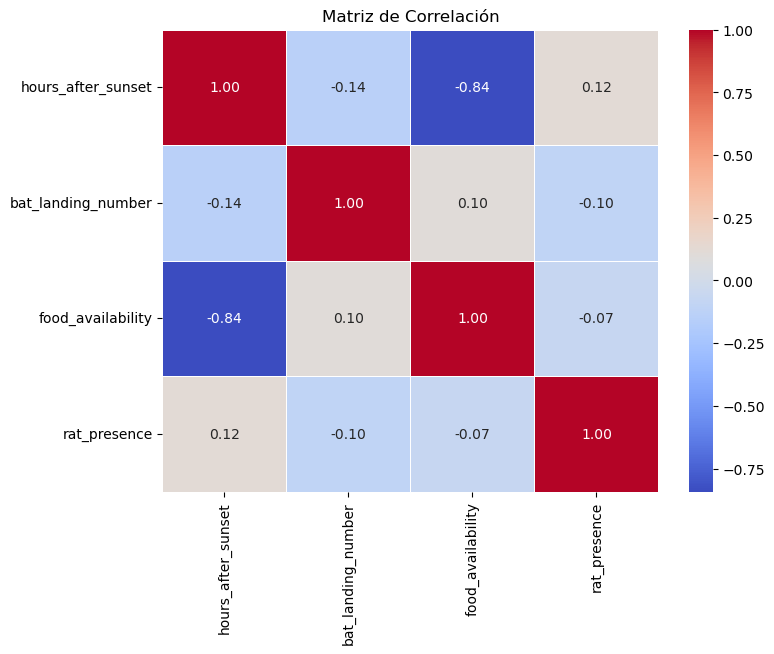

In [269]:
df2['rat_presence'] = (df2['rat_arrival_number'] > 0).astype(int)
cols = ['hours_after_sunset', 'bat_landing_number', 'food_availability', 'rat_presence']

corr = df2[cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Conclusions

When examining the correlation matrix, we can observe the following:

1. There is a weak negative correlation between bat landings and the presence of rats (-0.1). This suggests that bats, although only slightly, tend to avoid landing when rats are present.

2. Food availability decreases as the night progresses, shown by its strong negative correlation with hours after sunset (-0.84).

3. Food availability shows a weak positive correlation with bat landings (0.1) and a weak negative correlation with rat presence (-0.07).

4. Rat presence has a weak positive correlation with hours after sunset (0.12) and a weak negative correlation with food availability (-0.07).

Although these correlations are not strong, we can infer the following:

1. The presence of rats slightly reduces the number of bat landings (bats avoid rats).

2. Bats tend to feed earlier than rats, at times when food availability is higher.

These conclusions are not strong enough to support a definitive analysis; they are only initial points of reference for conducting a more detailed statistical study.

Overall, there is no clear relationship between the time of day and the appearance of either rats or bats. This suggests that neither species exhibits a pronounced temporal pattern in their activity.

The only clear observation is that as the night progresses, food availability declines.

### Relation between Bats landings and Rats Arrivals
We will use a scatter plot to visualize the correlation between bat landings and rat arrivals. This will help us identify whether any groups of data exhibit interesting correlations.

Hint: her we evaluate rats_arriving because rat_presence is a binomial variable and both variables have similar mean in this case.


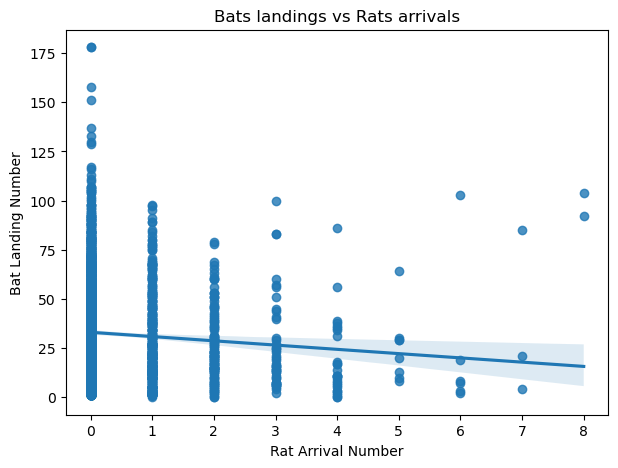

In [270]:
# BAT LANDING VS RATS ARRIVALS
# Delete outliyer
df2 = df2[df2['rat_arrival_number'] != 17]
plt.figure(figsize=(7,5))
sns.regplot(x='rat_arrival_number', y='bat_landing_number', data=df2)
plt.title('Bats landings vs Rats arrivals')
plt.xlabel('Rat Arrival Number')
plt.ylabel('Bat Landing Number')
plt.show()

From the graph, we can see a weak negative correlation between the two variables (-0.07, according to the correlation matrix). We already expected the correlation to be weak, but we were looking for any group of data that might exhibit different behavior. Aside from a few isolated cases, no group of cases behaves differently.

### Pearson Test to Evaluate the Statistical Significance of the Correlation Between Bats_Landings and Rat_Presence

We will apply a Pearson correlation test to evaluate whether the relationship between bats_landings and rat_presence is statistically significant. Although the observed correlation is weak, it is important to test its significance, since the strength of a correlation does not necessarily imply statistical significance.

H0: ρ = 0 => Don't exist correlation
H1: ρ ≠ 0 => Exist correlation

p-value < α, we reject H0 and exist correlation.

In [271]:
# Pearson Test to Evaluate the Statistical Significance of the Correlation Between Bats_Landings and Rat_Presence.

correlation, p_value = pearsonr(df2['rat_presence'], df2['bat_landing_number'])

print(f"Correlación: {correlation:.4f}")
print(f"P-valor: {p_value:.4f}")

Correlación: -0.1015
P-valor: 0.0000


Conclusion: exist correlation between Bats_landing and rat_presence.

Although a correlation exists, we need a more robust statistical analysis to demonstrate that bat_landings decrease due to rat_presence, because correlation does not imply causation.

# Two Tails Hypothesis Test
We will create two groups based on the presence of rats (rat_presence) and compare the mean number of bat landings between these two groups using a t-test for independent samples.

H0: μ1 = μ2 => No difference in bat landings between the two groups.
H1: μ1 ≠ μ2 => There is a difference in bat landings between the two groups.



In [288]:
# Create two groups based on the presence of rats (rat_presence).
group_without_rats = df2[df2['rat_presence'] == 0]['bat_landing_number']
group_with_rats = df2[df2['rat_presence'] == 1]['bat_landing_number']

# Central Tendency and Dispersion of both groups
mean1 = np.mean(group_without_rats)
mean2 = np.mean(group_with_rats)
std1  = np.std(group_without_rats, ddof=1)
std2 = np.std(group_with_rats, ddof=1)
n1 = len(group_without_rats)
n2 = len(group_with_rats)

# Z Stadistic
se12 = sqrt((std1**2 / n1) + (std2**2 / n2))
z_stat = (mean1 - mean2) / se12

# P-value bilateral
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

print(f"Estadístico Z: {z_stat}")
print(f"covariance: {se12}")
print(f"mean1 - mean 2: {mean1} - {mean2}")
print(f"n1 y n2: {n1} - {n2}")
print(f"Diff std: {sqrt((std1**2 / n1) + (std2**2 / n2))}")
print(f"z_statistic: {z_stat}")
print(f"P-value: {p_value}")

Estadístico Z: 5.094105366702224
covariance: 1.1692656254628664
mean1 - mean 2: 33.60709759188847 - 27.65073529411765
n1 y n2: 1578 - 544
Diff std: 1.1692656254628664
z_statistic: 5.094105366702224
P-value: 3.5039186596641514e-07


Conclusion: con P-value: 3.5e-07 < 0.05, we reject H0 with a 95% of confidence because the data don't support H0. This means that exist a significant diference between both goups. To analize if the difference between both groups we will do a confidence Interval between tha difference of both means.

In [ ]:
# Means difference
diff_means = mean1 - mean2

# Standard Error difference
se12 = sqrt((std1**2 / n1) + (std2**2 / n2))

# Z critical value for 95% confidence
z = norm.ppf(1 - 0.05/2)

# Intervalo de confianza
ci_lower = diff_means - z * se12
ci_upper = diff_means + z * se12

print(f"Mean difference: {diff_means}")
print(f"Confidence Interval of 95%: ({ci_lower}, {ci_upper})")

Mean difference: 5.95636229777082
Confidence Interval of 95%: (3.664643783502902, 8.248080812038738)


This mean that with a 95% of probability the mean of bats_landings is between 3.6 to 8.25 more landings without rats than with rats. Since the value 0 is not within the confidence interval, we reject the null hypothesis that there is no difference between the means.

### Final Conclusion: A Balance of Caution and Boldness Between Bats and Rats

This analysis shows a complex interaction between bats and rats at the feeding platform. Their behavior is not the same for all individuals and can change depending on rat exposure over time.

At the population level (df2), the presence of rats clearly deters bats: more rat activity is linked to fewer bat landings, suggesting that most bats perceive rats as a risk.

However, some individual bats (df1) show remarkable boldness. When we analyze the bats that do land, they feed directly in the presence of rats without waiting for them to leave. This paradox—general caution but individual boldness—may result from self-selection, where only the boldest or most experienced bats are confident enough to land and feed despite rats.

This boldness could be learned through repeated exposure to rats, with some bats becoming accustomed to their presence and realizing that the reward of food outweighs the risk (which might be reflected in an increase in the mean of bats eating with rats over time). Alternatively, it could reflect natural differences between bats, where the group that lands and feeds in the presence of rats is naturally bold, while others are more cautious.

In the next analysis, we will explore whether this bold behavior develops over time as more bats adopt it, or if it is simply a trait of a specific subgroup of bats.

# Analysis of Boldness as a Learned Behavior

To examine whether boldness is a learned behavior or simply a trait found in certain individuals within the population, we will evaluate the mean of BATS_EAT_WITH_RATS over time. If the mean increases as the months go by, it would suggest that bats are gradually becoming less fearful of rats, having learned that they do not pose a real threat. However, if the mean remains stable or decreases, this would indicate that boldness is not a learned behavior but rather an inherent trait that only certain individuals possess, enabling them to feed in the presence of rats without being intimidated.

# Grafic Analysis

To determine whether boldness (the willingness to feed in the presence of rats) is a learned behavior or an intrinsic trait exhibited only by certain individuals in the population, we evaluated the temporal evolution of the variable BATS_EAT_WITH_RATS.

Specifically, we calculated the 7-day moving average of the daily mean of this variable over the six months of the study. Using a moving average allows us to smooth out daily fluctuations and better capture the underlying trend.

Positive reinforcement: If the mean increases over time, this would suggest that bats progressively learn that rats do not pose a threat, thereby developing bolder behavior.

Negative reinforcement: If the mean decreases, it would indicate that bold individuals learn that, although rats are not predators, eating in their presence is an energy-draining situation, so they try to avoid feeding when rats are around.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


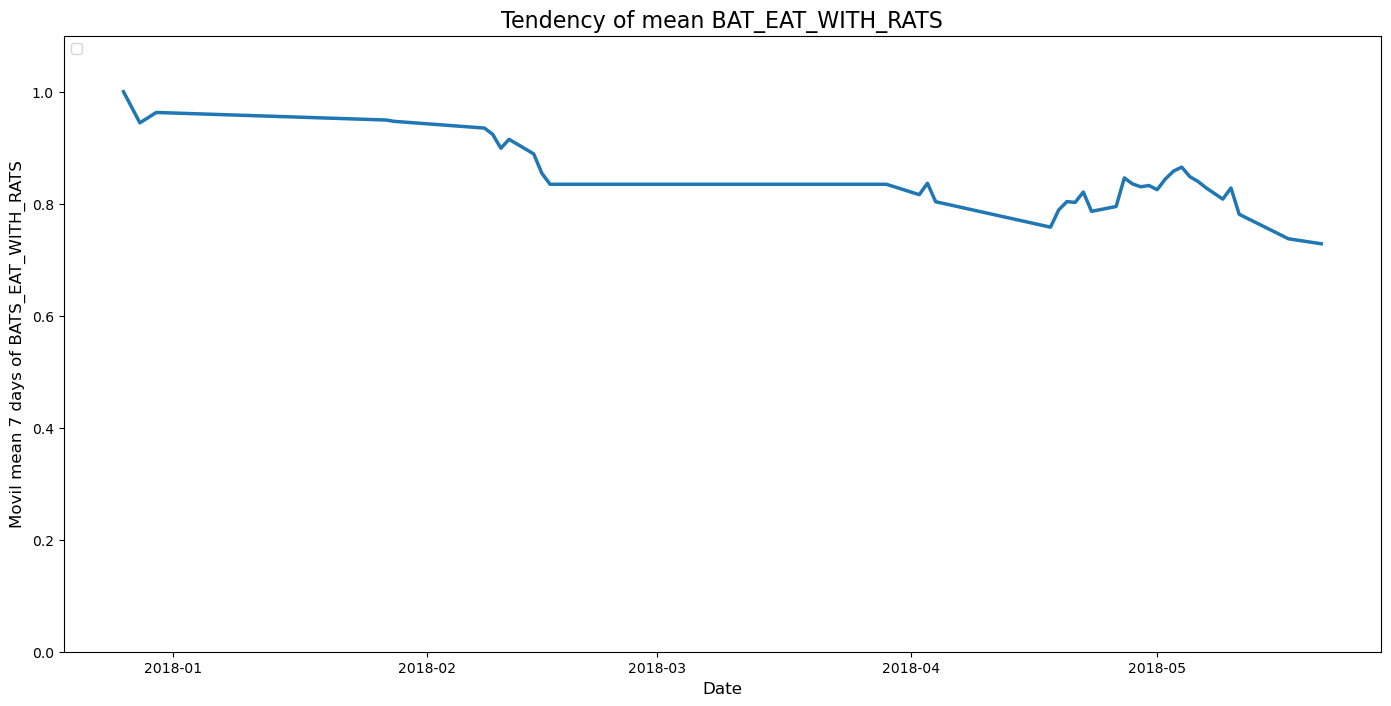

In [316]:
# First: Prepare the data of BATS_EAT_WITH_RATS
df1['DATE'] = pd.to_datetime(df1['DATE'], format='%d/%m/%Y')
BAT_EAT_WITH_RATS_DAILY = df1.groupby('DATE')['BAT_EAT_WITH_RAT'].agg(['mean', 'count'])
# Filter days with at least 5 observations (avoid noise)
BAT_EAT_WITH_RATS_DAILY_FIL = BAT_EAT_WITH_RATS_DAILY[BAT_EAT_WITH_RATS_DAILY['count'] >= 5]['mean']
# Calculate the 7-day moving mean
BAT_EAT_WITH_RATS_DAILY_MOVING_MEAN = BAT_EAT_WITH_RATS_DAILY_FIL.rolling(window=7, min_periods=1).mean()

# Plot the trend line
fig, ax = plt.subplots(figsize=(17, 8))
ax.plot(BAT_EAT_WITH_RATS_DAILY_MOVING_MEAN.index, BAT_EAT_WITH_RATS_DAILY_MOVING_MEAN, color='tab:blue', linewidth=2.5)


ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel( 'Movil mean 7 days of BATS_EAT_WITH_RATS', fontsize=12)
ax.set_title('Tendency of mean BAT_EAT_WITH_RATS', fontsize=16)
ax.tick_params(axis='y')
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left')

plt.show()

Conclusion: Learning through Negative Reinforcement
The decreacing tendency of the mean of BAT_EAT_WITH_RATS shows that rather becoming habituated, the bats are learning that continued interaction with the rats is, in the long run, negative. The possible reasons could be:

Energy Cost: Constant competition for food is exhausting.

Stress: Proximity to a competitor, even if not a predator, generates stress that cumulatively outweighs the benefit of food.

Annoyance: The rats may be stealing their food or simply interrupting their feeding.